## Model cost/watt as function of two features: time (days), size (kilowatts)

Add feature *size_kw* to model (cost ~ days, size)

### Summary of results

OLS is better able to capture the trend of the data by including both *time* and *size* in the model (with a polynomial transformation). We did a 3-fold cross-validated test on the full dataset (364k rows) from polynomial degree 1 to degree 17 measuring $R^2$ and the square root of the squared error (RMSE).

The 14th degree polynomial has the best fit (test  $R^2$  = 0.517). At higher polynomials, the model overfits and test performance deteriorates.  The validation curve for polynomial degree suggests that with regularization, we may be able to increase the model flexibility (increase polynomial degree) without overfitting and improve performance.

Before adding regularization we add *state* as feature to the model to see if we can capture more of the variation in the model by providing more information to work with.

Best parameters: {'poly__degree': 14}
Best R squared: 0.5169444705591224

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [2]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
# read cleaned data
dfModelAll = pd.read_csv('../local/data/LBNL_openpv_tts_data/ModelAll.csv', index_col='row', dtype={'state':'category'})

In [4]:
dfModelAll.head()

,num_days,size_kw,state,cost_per_watt,scaleSize
row,,,,,
0,0.0,2.2824,CA,10.734315,0
1,21.0,1.8504,CA,11.108701,0
2,26.0,2.3076,CA,8.667013,0
3,84.0,2.3316,CA,13.270286,0
4,111.0,0.9300,CA,14.654839,0


In [5]:
dfModelAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364212 entries, 0 to 364211
Data columns (total 5 columns):
num_days         364212 non-null float64
size_kw          364212 non-null float64
state            364212 non-null category
cost_per_watt    364212 non-null float64
scaleSize        364212 non-null int64
dtypes: category(1), float64(3), int64(1)
memory usage: 14.2 MB


In [6]:
dfModelAll.state.unique()

[CA, OR, AZ, NY, MN, ..., MD, CT, FL, NM, AR]
Length: 19
Categories (19, object): [CA, OR, AZ, NY, ..., CT, FL, NM, AR]

#####  There is a  choice to deal with encoding of categorical variable 'state' with pandas or in the pipeline.  I don't want to make polynomial terms for the state.  For now, we defer to next step.

In [7]:
dfModelAll.get_dtype_counts()

category    1
float64     3
int64       1
dtype: int64

### Shuffle

In [8]:
dfMod = dfModelAll.sample(frac=1.0, random_state=21)

In [9]:
len(dfModelAll), len(dfMod)

(364212, 364212)

### Set up a sklearn pipeline

In [10]:
# set up to model two features, num_days, size_kw
X = dfMod[['num_days', 'size_kw']].values
y = dfMod[['cost_per_watt']].values
X.shape, y.shape

((364212, 2), (364212, 1))

###  check summary stats for cost

In [11]:
np.std(dfModelAll.cost_per_watt)

2.1487016159206926

In [12]:
np.mean(dfModelAll.cost_per_watt)

5.477365160843267

In [13]:
np.median(dfModelAll.cost_per_watt)

4.920527472527473

### Make a pipeline with the appropriate steps

In [14]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('poly', PolynomialFeatures()),
         ('LR', LinearRegression())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

In [15]:
# what's in the pipeline?
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaler', 'poly', 'LR', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'poly__degree', 'poly__include_bias', 'poly__interaction_only', 'LR__copy_X', 'LR__fit_intercept', 'LR__n_jobs', 'LR__normalize'])

### Search for best polynomial degree

In [16]:
# Specify the hyperparameter space.
# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 4)
param_grid = {'poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# Create the GridSearchCV object: gm_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, return_train_score=True)

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(r2))

Best parameters: {'poly__degree': 3}
test R squared: 0.4850506445537449


In [17]:
# this will show the results data structure
# gs_cv.cv_results_

#### Add  RMSE to the results along with $R^2$

In [18]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Specify the hyperparameter space; .
# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 18)
param_grid = {'poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=21)

# Create the GridSearchCV object: gs_cv
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

gs_cv = GridSearchCV(pipeline, param_grid, cv=3, 
                     scoring=scoring, return_train_score=True,
                     refit='Rsquared')

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(r2))

# uncomment to see results ds
# gs_cv.cv_results_

Best parameters: {'poly__degree': 14}
Best R squared: 0.5169444705591224


In [19]:
list(zip(gs_cv.cv_results_['param_poly__degree'], 
         gs_cv.cv_results_['mean_test_Rsquared'], 
         np.abs(gs_cv.cv_results_['mean_test_RMSE'])))

[(1, 0.43615624720465884, 1.6167187406596424),
 (2, 0.4568950387057746, 1.5867071604130252),
 (3, 0.47935889232215195, 1.553549099646355),
 (4, 0.49255724263533907, 1.5337307785741787),
 (5, 0.4949670988738195, 1.5300837366874143),
 (6, 0.5055689098605497, 1.513935166325809),
 (7, 0.5064389887822234, 1.5126045849024794),
 (8, 0.5089298717716142, 1.508781942216268),
 (9, 0.5089825717803976, 1.5087037060606392),
 (10, 0.5100909017641931, 1.506995369892249),
 (11, 0.5101925337900831, 1.50683290218898),
 (12, 0.5064495960589106, 1.5125924159727793),
 (13, 0.5095854444990946, 1.5077777066495288),
 (14, 0.5116243600096734, 1.5046350539925855),
 (15, 0.49953444755264137, 1.523019849798034),
 (16, 0.3667455757601547, 1.6971041728146259),
 (17, -0.7692602873496219, 2.6832583318126617)]

In [20]:
gs_cv.cv_results_

{'mean_fit_time': array([0.0455, 0.0755, 0.1176, 0.1912, 0.263 , 0.3519, 0.484 , 0.639 ,
        0.8372, 1.0551, 1.5391, 1.7142, 1.9295, 2.2791, 2.6641, 3.0621,
        3.6561]),
 'mean_score_time': array([0.0214, 0.0211, 0.0455, 0.0715, 0.1283, 0.1651, 0.2453, 0.3336,
        0.4388, 0.5831, 0.7988, 0.9138, 1.1257, 1.2416, 1.487 , 1.7347,
        2.2829]),
 'mean_test_RMSE': array([-1.6167, -1.5867, -1.5535, -1.5337, -1.5301, -1.5139, -1.5126,
        -1.5088, -1.5087, -1.507 , -1.5068, -1.5126, -1.5078, -1.5046,
        -1.523 , -1.6971, -2.6833]),
 'mean_test_Rsquared': array([ 0.4362,  0.4569,  0.4794,  0.4926,  0.495 ,  0.5056,  0.5064,
         0.5089,  0.509 ,  0.5101,  0.5102,  0.5064,  0.5096,  0.5116,
         0.4995,  0.3667, -0.7693]),
 'mean_train_RMSE': array([-1.6167, -1.5867, -1.5535, -1.5336, -1.5299, -1.5133, -1.5114,
        -1.5082, -1.5071, -1.5058, -1.5045, -1.5033, -1.5024, -1.5018,
        -1.501 , -1.4999, -1.4991]),
 'mean_train_Rsquared': array([0.4362, 0.456

### Plot curves for best fit model.

Best parameters: {'poly__degree': 14}
Best R squared: 0.5169444705591224


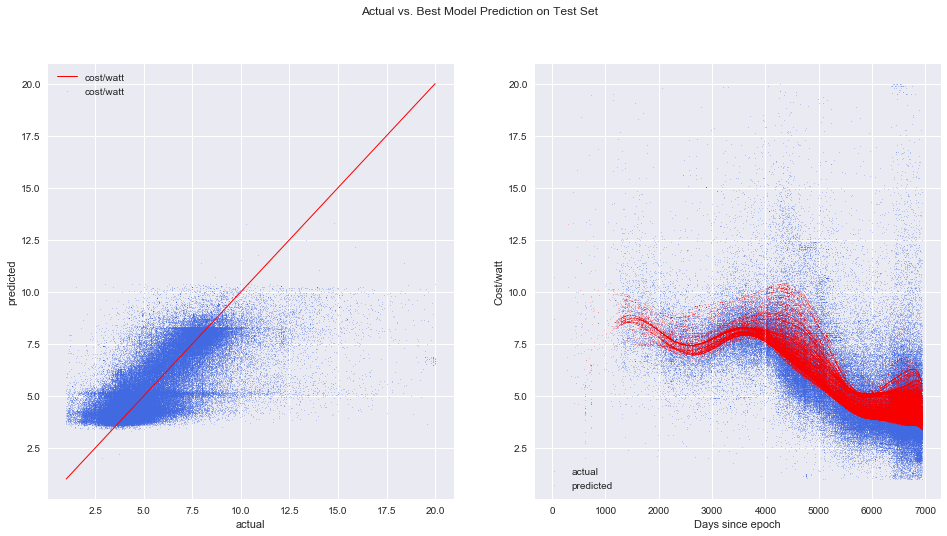

In [21]:
# Compute and print the metrics
r2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(r2))

prediction = gs_cv.predict(X_test)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, prediction, marker='.', s=2, alpha=0.3, color='royalblue', label='cost/watt')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='cost/watt')
ax1.set_ylabel('predicted')
ax1.set_xlabel('actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=2, alpha=0.3, label='actual')
ax2.scatter(X_test[:, 0], prediction, marker='.', color='red', s=2, alpha=0.2, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('Days since epoch')
ax2.legend()

plt.show();

In [22]:
def trainVsTestResults(results): 
    ''' Plot test/train results for R^2 and RMSE'''    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean train/test RMSE and R^2 vs poly degree'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(np.arange(1, n + 1), np.abs(mean_train_RMSE), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax1.plot(np.arange(1, n + 1), np.abs(mean_test_RMSE), marker='*', ms=10, alpha=1.0, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('polynomial degree')
    ax1.set_title('mean train/test RMSE vs poly degree')
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_))

    ax2.plot(np.arange(1, n + 1), np.abs(mean_train_R2), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax2.plot(np.arange(1, n + 1), np.abs(mean_test_R2), marker='*', ms=10, color='red', label='test')
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('polynomial degree')
    ax2.set_title('mean train/test R2 vs poly degree')
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best R squared: {}".format(r2))

Best parameters: {'poly__degree': 14}
Best R squared: 0.5169444705591224


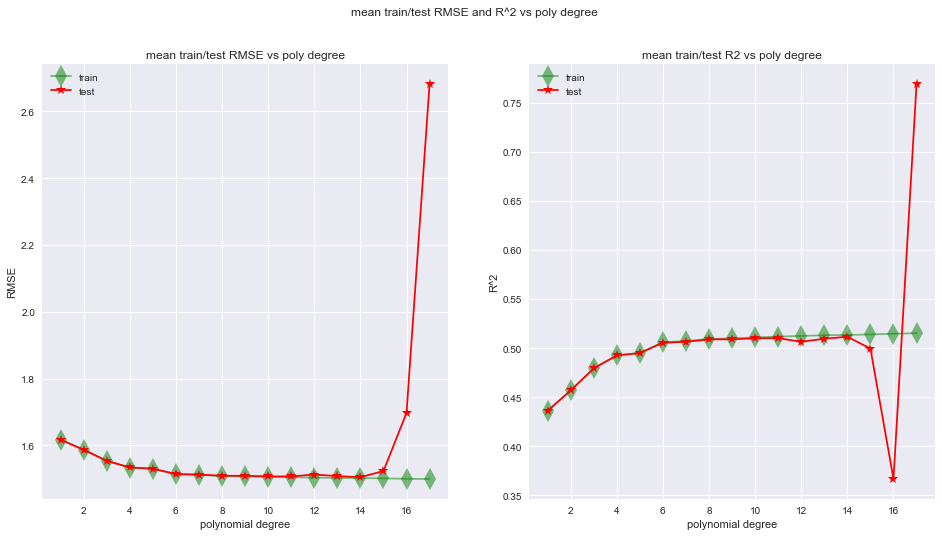

In [23]:
trainVsTestResults(gs_cv.cv_results_)